In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-wildfire-dataset


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [4]:
#To ensure the GPU is present
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print('GPU is Available!')
else:
  print('GPU is Unavailable!')

GPU is Available!


In [5]:
train_dir = "/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/train"
val_dir = "/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/val"
test_dir = "/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test"


In [6]:
# List all the classes
classes = os.listdir(train_dir)
num_classes = len(classes)

# Display the class names
print(f'Number of classes : {num_classes}')
print(f'Classes : {classes}')


Number of classes : 2
Classes : ['nofire', 'fire']


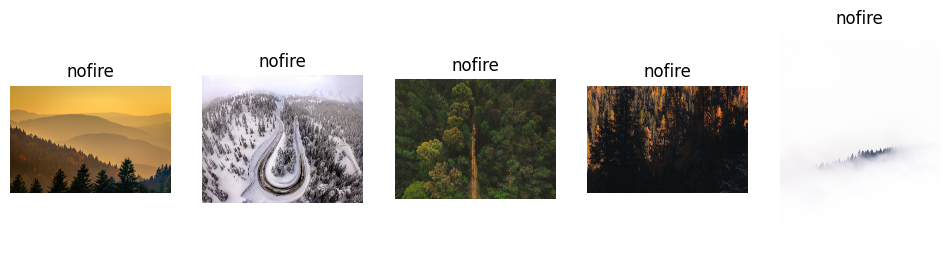

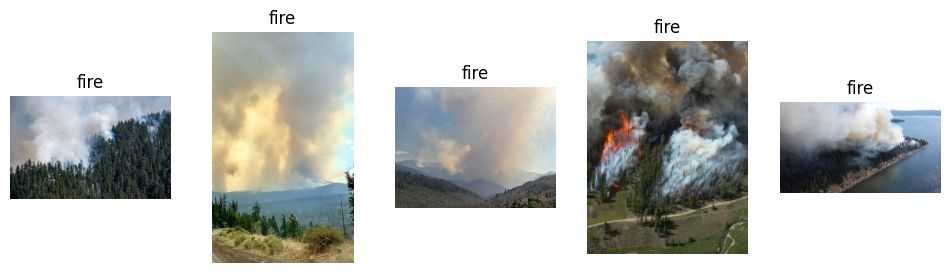

In [7]:
# Visualize samples
for class_label in classes:
    plt.figure(figsize=(12, 3))
    for i in range(5):
        img_path = os.path.join(train_dir, class_label, os.listdir(os.path.join(train_dir, class_label))[i])
        img = plt.imread(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(class_label)
        plt.axis('off')
    plt.show()

In [8]:
# Set image properties
img_width, img_height = 150, 150
batch_size = 32

In [9]:
# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
# Data loaders
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary', shuffle=True)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary', shuffle=True)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary', shuffle=False)


Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


In [13]:
# Class mapping
class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

Class Names: ['fire', 'nofire']


In [14]:
# Model architecture
model = Sequential([
    Input(shape=(img_width, img_height, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint("./best_model.keras", save_best_only=True)
]

In [18]:
# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks
)

Epoch 1/20
 4/58 ━━━━━━━━━━━━━━━━━━━━ 6:05 7s/step - accuracy: 0.6003 - loss: 0.7590

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


39/58 ━━━━━━━━━━━━━━━━━━━━ 2:12 7s/step - accuracy: 0.6242 - loss: 0.6768

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


58/58 ━━━━━━━━━━━━━━━━━━━━ 509s 9s/step - accuracy: 0.6234 - loss: 0.6696 - val_accuracy: 0.6797 - val_loss: 0.5594
Epoch 2/20
 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7812 - loss: 0.5541

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


58/58 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7812 - loss: 0.5541 - val_accuracy: 0.6615 - val_loss: 0.5816
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 505s 8s/step - accuracy: 0.6410 - loss: 0.6004 - val_accuracy: 0.6250 - val_loss: 0.6495
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5938 - loss: 0.7141 - val_accuracy: 0.6250 - val_loss: 0.6483
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 470s 8s/step - accuracy: 0.7319 - loss: 0.5209 - val_accuracy: 0.6797 - val_loss: 0.5400
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7500 - loss: 0.5037 - val_accuracy: 0.6667 - val_loss: 0.5483
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 482s 8s/step - accuracy: 0.7284 - loss: 0.5274 - val_accuracy: 0.7656 - val_loss: 0.5029
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7500 - loss: 0.4440 - val_accuracy: 0.7552 - val_loss: 0.5123
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 482s 8s/step - accuracy: 0.7600 - loss: 0.5232 - val_accuracy: 0.7344 - val_loss: 0.509

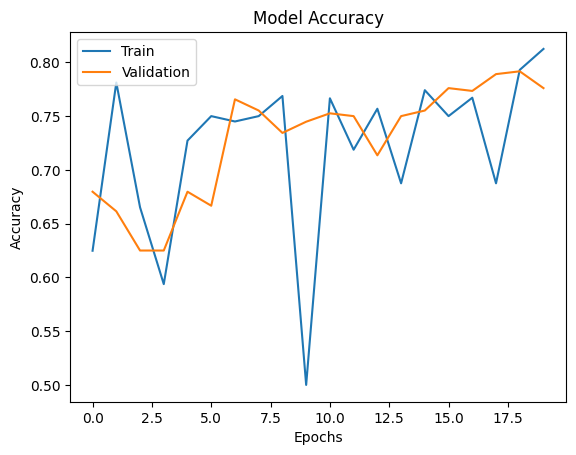

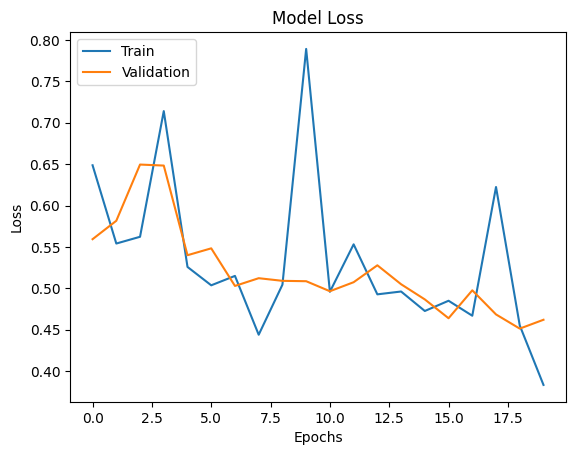

In [19]:
# Plot accuracy & loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Accuracy: {test_acc:.4f}')

 5/12 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.7451 - loss: 0.5761

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


 6/12 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.7468 - loss: 0.5754

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 87s 8s/step - accuracy: 0.7777 - loss: 0.5125
Test Accuracy: 0.8177


In [21]:
# Detailed metrics
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes[:len(y_pred_classes)]
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

12/12 ━━━━━━━━━━━━━━━━━━━━ 87s 7s/step
Classification Report:
               precision    recall  f1-score   support

        fire       0.80      0.74      0.77       159
      nofire       0.83      0.87      0.85       225

    accuracy                           0.82       384
   macro avg       0.81      0.81      0.81       384
weighted avg       0.82      0.82      0.82       384

Confusion Matrix:
 [[118  41]
 [ 29 196]]


In [22]:
# Save model
model.save('./FFD.keras')